In [1]:
import numbers
import numpy as np
import pandas as pd
from pathlib import Path
from io import BytesIO
import sys
import json
import pprint
from mplsoccer import Pitch
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Literal
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
import math
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import image
from datetime import date, datetime


matchids = [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725,
2015213, 2017461]



 

In [41]:

#Previously created classes for final proj. Will rewrite useful xpass stuff in below class. Going to reuse dataloader from here since that is only really applicable to me

class Validators:

    @staticmethod
    def ensure_list_of_ints(input_val: int | list[int]) -> list[int]:
        if isinstance(input_val, int):
            return [int(input_val)]   
        if isinstance(input_val, list):
            if all(isinstance(x, numbers.Integral) for x in input_val):
                return [int(x) for x in input_val]
            else:
                raise TypeError('You passed a list (good!), but not all values were integers')

        raise TypeError(f'You must pass a list or int. You passed {type(input_val)}')
    
    @staticmethod
    def ensure_player_id_int(input_val: int):
        if isinstance(input_val, int):
            return input_val
        else:
            raise TypeError(f'You must pass an int. You passed {type(input_val)}')

class DataLoaderSingleMatch:
    def __init__(self, match_id: int):
        self.match_id: int = match_id
    
    def dynamic_events_path(self) -> str:
        return f'{self.match_id}/{self.match_id}_dynamic_events.csv'
    @property
    def match_info_file_name(self) -> str:
        return f'{self.match_id}/{self.match_id}_match.json'
    
    def load_match_info(self) -> pd.DataFrame:
        with open(self.match_info_file_name) as f:
            match_dict = json.load(f)
            df = pd.json_normalize(match_dict)
        return df  
    
class DataLoader:
    def __init__(self, match_ids: int | list[int]) -> None:
        self.match_ids: list[int] = Validators.ensure_list_of_ints(match_ids)

    xx_test_matchids = (1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461)

    @classmethod
    def data_loader_single_match(cls, match_id: int):
        file_name= DataLoaderSingleMatch(match_id).dynamic_events_path()
        match: pd.DataFrame = pd.read_csv(file_name, low_memory= False)
        return match

    def data_loader_multi_match(self, match_ids = None) -> pd.DataFrame:
        
        if match_ids == None: match_ids = self.match_ids

        all_match_dfs: list[pd.DataFrame] = []
        for match_id in match_ids:
            match: pd.DataFrame = self.data_loader_single_match(match_id = match_id)
            all_match_dfs.append(match)
        all_matches= pd.concat(all_match_dfs, ignore_index =True)
        return all_matches

    def data_loader_single_json(self, match_id: int) -> pd.DataFrame:
        obj = DataLoaderSingleMatch(match_id=match_id)
        return obj.load_match_info()

    def data_loader_multi_json(self, match_ids = None):
        if match_ids == None: match_ids = self.match_ids
        objs: list[DataLoaderSingleMatch] = []
        for i in match_ids:
            objs.append(DataLoaderSingleMatch(i))
        list1 = []
        for obj in objs:
            list1.append(obj.load_match_info())
        df = pd.concat(list1)
        return df
    
class FieldZone:

    zone_values: dict[int, tuple[str, str]] = {
            1: ("depth_1", "width_left"),
            2: ("depth_1", "width_center"),
            3: ("depth_1", "width_right"),
            4: ("depth_2", "width_left"),
            5: ("depth_2", "width_center"),
            6: ("depth_2", "width_right"),
            7: ("depth_3", "width_left"),
            8: ("depth_3", "width_center"),
            9: ("depth_3", "width_right"),
            10: ("depth_4", "width_left"),
            11: ("depth_4", "width_center"),
            12: ("depth_4", "width_right"),
            13: ("depth_5", "width_left"),
            14: ("depth_5", "width_center"),
            15: ("depth_5", "width_right"),
            16: ("depth_6", "width_left"),
            17: ("depth_6", "width_center"),
            18: ("depth_6", "width_right"),
            19: ("depth_5", "half_space_left"),
            20: ("depth_5", "half_space_right"),
        }

    def __init__(self, df_data: pd.DataFrame) -> None:
        self.df_data: pd.DataFrame = df_data


    def get_depth_mask(self, depth_term: str) -> pd.Series:
        x_starts: pd.Series[float] = self.df_data['x_start']
        match depth_term:
            case 'depth_1':
                return x_starts <= -35.34
            case 'depth_2':
                return x_starts.between(-35.34, -17.66, inclusive= 'right')
            case 'depth_3':
                return x_starts.between(-17.66, 0, inclusive = 'right')
            case 'depth_4':
                return x_starts.between(0, 17.66, inclusive = 'right')
            case 'depth_5':
                return x_starts.between(17.66, 35.34, inclusive = 'right')
            case 'depth_6':
                return x_starts >= 35.34
            case _:
                raise ValueError('You did not pass a valid depth term')
            

    def get_width_mask(self, width_term: str) -> pd.Series:
        y_starts: pd.Series[float] = self.df_data['channel_id_start']
        match width_term:
            case 'width_left':
                return y_starts.isin([1,2])
            case 'width_center':
                return y_starts == 3
            case 'width_right':
                return y_starts.isin([4,5])
            case 'half_space_left':
                return y_starts == 2
            case 'half_space_right':
                return y_starts == 4
            case _:
                raise ValueError('You did not pass a valid width term')
    



    def get_zone_defined_possessions(self, zone: int) -> pd.DataFrame:
        """
        Input a dataframe of dynamic events data and in integer between 1 and 20. Returns all possessions in static possession that begin in that zone.
        Zones defined as such: https://learning.coachesvoice.com/wp-content/webpc-passthru.php?src=https://learning.coachesvoice.com/wp-content/uploads/2022/05/Tactics1.png&nocache=1
        Input 19 for the left attacking half space, and 20 for the right attacking half space

        Composite key for each record: 'match_id' and 'event_id'
        """
        data = self.df_data.copy()
        #Keep only player possessions
        is_possession: pd.Series[bool] = data['event_type'] == 'player_possession'
        #Keep only possessions vs blocks
        is_vs_block: pd.Series[bool] = data['team_out_of_possession_phase_type'].isin(['high_block', 'medium_block','low_block'])
  
        depth = self.get_depth_mask(self.zone_values[zone][0])

        width = self.get_width_mask(self.zone_values[zone][1])

        mask = is_possession & is_vs_block & depth & width
        
        filtered_df = data.loc[mask].copy()

        return filtered_df
    
    def get_zone_summary(self, zone: int):
    ### aggregator
        
        summary = (
            self.get_zone_defined_possessions(zone)
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                total_actions= ('player_name', 'count')
                )
        
        )
        minutes_counts = PlayerInfo(self.df_data).get_player_info()
        summary = summary.merge(minutes_counts, on = ['player_id'], how = 'left')
        summary['ta/90'] = summary['total_actions']/(summary['total_minutes']/90)
        summary = summary.sort_values('ta/90', ascending = False)
        return summary

class PlayerInfo:
    
    @staticmethod
    def age_from_datetime(series: pd.Series) -> pd.Series:
        """
        Calculate age in years from a pandas datetime64[ns] Series.
        """
        today = pd.Timestamp.today().normalize()

        age = today.year - series.dt.year

        had_birthday = (
            (today.month > series.dt.month) |
            ((today.month == series.dt.month) & (today.day >= series.dt.day))
        )

        return age - (~had_birthday).astype(int)
        
   
    def __init__(self, df_data: pd.DataFrame):
            df_data['match_id'] = df_data['match_id'].astype(int)
            self.df_data = df_data

    def list_from_df(self):
        list1 = []
        for id in self.df_data['match_id'].unique():
            list1.append(id)
        return list1
    
    def get_info_df(self):
        list1 = self.list_from_df()
        dl = DataLoader(list1)
        df_data = dl.data_loader_multi_json()
    
        all_players = []

        for _, row in df_data.iterrows():
            players = pd.json_normalize(row['players'], sep='>')
            all_players.append(players)

        df_players = pd.concat(all_players, ignore_index=True)
        df_players['birthday'] = pd.to_datetime(df_players['birthday'], errors='coerce')

        return df_players
    
    def get_player_info(self):
        df_data = self.get_info_df()

        out = (
            df_data
            .groupby('id')
            .agg(
                total_minutes=('playing_time>total>minutes_played', 'sum'),
                positions=('player_role>acronym',lambda x: sorted(set(x))),
                birthday=('birthday', 'first')  
            )
            .rename_axis('player_id')
        )
        
        out['age'] = PlayerInfo.age_from_datetime(out['birthday'])
        out = out.drop(columns='birthday')

      

 
        return out
    
    def get_player_matchids(self, player_id):
    
        player_df = self.df_data[self.df_data['player_id'] == player_id]

        ids = player_df['match_id'].unique()

        return ids
       
class PassingStats:

    def __init__(self, df_data: pd.DataFrame):
        self.df_data = df_data

    def prepare_dataframe_xpass(self):
        self.df_data = self.df_data[self.df_data['event_type_id'] == 8]
        self.df_data = self.df_data[self.df_data['pass_outcome_id'].isin([1,2])]
        
        return self.df_data

    def add_xpass_columns(self):
    
        self.df_data = self.df_data.copy()
        self.prepare_dataframe_xpass()
        self.df_data = self.df_data[self.df_data['player_targeted_xpass_completion'].notnull()]

        self.df_data['pass_success'] = (self.df_data['pass_outcome_id'] == 1).astype('Int64')
      

        self.df_data['pass_completion_vs_expected'] = (
            self.df_data['pass_success'] - self.df_data['player_targeted_xpass_completion']
        )

        return self.df_data

    def get_xpass_summary(self):
        self.df_data = self.add_xpass_columns()

        summary = (
            self.df_data
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                pass_completion_vs_expected=('pass_completion_vs_expected', 'sum'),
                expected_passes_completed = ('player_targeted_xpass_completion', 'sum'),
                total_passes=('player_name', 'count'),
                completed_passes = ('pass_success', 'sum'),
                difficult_passes=('player_targeted_difficult_pass_target', 'sum')
            )
        )

        return summary.sort_values('pass_completion_vs_expected', ascending=False)
    
    def get_player_xpass(self, player_id: int) -> pd.DataFrame:
        self.player_id =  Validators.ensure_player_id_int(player_id)

        summary = self.get_xpass_summary()

        try:
            player_row = summary.loc[player_id]
        except:
            raise KeyError(f"Player ID {player_id} not found in xPass summary.")
        
        return player_row

    def get_xpass_viz(self, player_id):
        xpass = self.add_xpass_columns()
        xpass = xpass[xpass['player_id'] == player_id]
        
       

        pitch = Pitch(pitch_type='skillcorner', pitch_length=106, pitch_width=68,
              axis=True, label=False)
        fig, ax = pitch.draw()

        cmap = plt.get_cmap('jet')

        for event in range(len(xpass)):
            row = xpass.iloc[event]
            if row['pass_outcome_id'] == 1:
                ax.plot(
                (row['x_end'], row['player_targeted_x_reception']),
                (row['y_end'], row['player_targeted_y_reception']),
                color= cmap(row['player_targeted_xpass_completion']), ls='solid'
                )
            elif row['pass_outcome_id'] == 2:
                ax.plot(
                (row['x_end'], row['player_targeted_x_pass']),
                (row['y_end'], row['player_targeted_y_pass']),
                color=cmap(row['player_targeted_xpass_completion']), ls='dashed'
                )

            ax.scatter(row['x_end'], row['y_end'], color = cmap(row['player_targeted_xpass_completion']), s=15, zorder=5)

            
        name: str = xpass['player_name'].unique()[0]
        
        plt.title('Pass map for ' + name)

        norm = Normalize(vmin=0, vmax=1)
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])

        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label("Expected Pass Completion")

        solid_line = mlines.Line2D([], [], color='black', linestyle='-',
                           label='Successful pass')
        dashed_line = mlines.Line2D([], [], color='black', linestyle='--',
                            label='Unsuccessful pass')

        ax.legend(handles=[solid_line, dashed_line],
            loc='lower center',
            bbox_to_anchor=(0.5, 1.05),   # X center, Y above axis
            frameon=False,
            ncol=2)
        return pitch
        
class ZoneMovers:
    bins = [-1000, -35.34, -17.66, 0, 17.66, 35.34, 1000]
    labels = [1, 2, 3, 4, 5, 6]
    
    def __init__(self, df_data: pd.DataFrame):
        self.df_data = df_data
    
    def get_zone_movers_carries(self, filter:bool = False):
        """
        input a dynamic events df, output a df with a zones_moved_forward field. Only considers zone moving carries Zones moved forwards are positive, zones moved backwards are negative

        if filter = True, returns a df of only zone moving carries. If false, returns a df of all player possessions with added zone mover columns
        """
  
        data = self.df_data.copy()
        
        moving = data.loc[data['event_type'] == 'player_possession'].copy()

        x_start_bucket = pd.cut(moving['x_start'], bins=ZoneMovers.bins, labels=ZoneMovers.labels)
        x_end_bucket   = pd.cut(moving['x_end'], bins=ZoneMovers.bins, labels=ZoneMovers.labels)


        moving['x_start_bucket'] = x_start_bucket.astype('int64')
        moving['x_end_bucket']   = x_end_bucket.astype('int64')

        moving['zones_moved_forward'] = x_end_bucket.astype('int64') - x_start_bucket.astype('int64')

        if filter is True:
            moving = moving.loc[moving['zones_moved_forward'] != 0]

        return moving
    
    def get_zone_movers_passes(self, filter:bool = False):

        data = self.df_data.copy()
        moving = data.loc[data['event_type'] == 'player_possession'].copy()
        moving = moving.loc[moving['player_targeted_x_reception'].isna() == False].copy()

        x_start_bucket = pd.cut(moving['x_end'], bins=ZoneMovers.bins, labels=ZoneMovers.labels)
        x_end_bucket   = pd.cut(moving['player_targeted_x_reception'], bins=ZoneMovers.bins, labels=ZoneMovers.labels)

   
        moving['pass_zone'] = x_start_bucket.astype(int)
        moving['reception_zone'] = x_end_bucket.astype(int)

    
        zones_moved_forward = moving['reception_zone'] - moving['pass_zone']
        zones_moved_forward = zones_moved_forward.fillna(0)
        moving['zones_moved_forward'] = zones_moved_forward.astype(int)
        if filter is True:
            moving = moving.loc[moving['zones_moved_forward'] != 0]

        return moving
    
    def get_zone_movers_summary_helper(self, type_: str = 'pass'):
    
        data = self.df_data.copy()
        if type_ == 'pass':
                df = self.get_zone_movers_passes()
        elif type_ == 'carry':
                df = self.get_zone_movers_carries()
        else:
            raise ValueError('type_ must be pass, carry, or both')
        summary = (
            df
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                zones_moved = ('zones_moved_forward', 'sum'))
        )
        info = PlayerInfo(data)
        minutes_counts = info.get_player_info()
        summary = summary.merge(minutes_counts, on = ['player_id'], how = 'left')
        summary['zm/90'] = summary['zones_moved']/(summary['total_minutes']/90)
        summary = summary.sort_values('zm/90', ascending = False)
    
        return summary
    
    def get_zone_movers_summary(self, type_: str = 'pass'):

        """
        Generates zone mover summary from Dynamic Events dataframe. 

        Accepts a dataframe of dynamic events and a string reading "pass", "carry", or "both" to determine type
        """
        
        if type_ == 'pass':
            summary = self.get_zone_movers_summary_helper('pass')
        elif type_ == 'carry':
            summary = self.get_zone_movers_summary_helper('carry')
        elif type_ == 'both':
            df1 = self.get_zone_movers_summary_helper('pass')
            df2 = self.get_zone_movers_summary_helper('carry')
            summary = df1.merge(df2, on = ['player_id', 'player_name','total_minutes'], how = 'left')
            columns_drop = ( ['positions_y'])
            summary = summary.drop(columns_drop, axis = 1)
            new_order = [	'player_name', 'total_minutes', 'positions_x' ,	'zones_moved_x', 	'zm/90_x',	'zones_moved_y',	'zm/90_y']
            summary = summary.reindex(columns=new_order)
            summary.rename(columns={'positions_x': 'positions', 'zones_moved_x' : 'zones_moved_passing', 'zones_moved_y' : 'zones_moved_carrying',
                                'zm/90_x' : 'zmp/90', 'zm/90_y' : 'zmc/90'}, inplace=True)
            summary['zones_moved'] = summary['zones_moved_passing'] + summary['zones_moved_carrying']
            summary['zm/90'] = summary['zmp/90'] + summary['zmc/90']
            summary = summary.sort_values('zm/90', ascending = False)
        else: 
            raise ValueError('type_ must be pass, carry, or both')
        

        return summary
    

    def get_zone_movers_viz(self, player_id: int):
        """
        takes a SkillCorner dynamic events df and a playerid
        generates a pitch visualization of a player's (successful) zone movers in a given df
        green dashed lines are passes, red solid lines are runs with the ball

        needs matplotlib pyplot, seaborn, mplsoccer
        """
        
        passes  = self.get_zone_movers_passes(True)

        carries = self.get_zone_movers_carries(True)

    
        pp = passes.loc[passes['player_id'] == player_id]
        pc = carries.loc[carries['player_id'] == player_id]

  
        pitch = Pitch(pitch_type='skillcorner', pitch_length=106, pitch_width=68,
                axis=True, label=True, positional=True, shade_middle=True)
        fig, ax = pitch.draw()

        for event in range(len(pp)):
            row = pp.iloc[event]
            ax.plot(
            (row['x_end'], row['player_targeted_x_reception']),
            (row['y_end'], row['player_targeted_y_reception']),
            color='green', ls='dashed'
            )

            ax.scatter(row['x_end'], row['y_end'], color='green', s=40, zorder=5)

        for event in range(len(pc)):
            row = pc.iloc[event]
            ax.plot(
            (row['x_start'], row['x_end']),
            (   row['y_start'], row['y_end']),
            color='red'
            )

            ax.scatter(row['x_start'], row['y_start'], color='red', s=40, zorder=5)
    
        name: str = pp['player_name'].unique()[0]
        plt.title('Zone mover map for ' + name)

    
        return pitch
    







In [102]:


class ASIProjMetrics:

    """
    Create a suite of passing metrics for the Adam Wharton section. Focusing on progression, chance creation, risk taking, and high importance passing. 

    Metrics in progress: chances created/sca

    Metrics completed: Xpass,  Xthreat added passing, line breaks, SkillCorner Difficult Passes (%?), forward passes, takes most threatening option

    """
    AGG_REGISTRY = {
        'xthreat_added_passing_aggregator': ['player_name', 'xthreat_added_passing_per_90'],
        'line_breaking_passes_aggregator': ['lines_broken_per_90'],
        'shot_creating_aggregator': ['passes_leading_to_shot_per_90', 'shot_creating_actions_per_90'],
        'miscellaneous_stats_aggregator' : ['percent_dangerous_passes', 'percent_difficult_passes', 'percent_forward_passes'],
        'xpass_summary_aggregator' : ['pass_completion_vs_expected']

    }

    POS_REGISTRY = {'LDM','DM','RDM','CM'}

    def __init__(self, df_data: pd.DataFrame):
         self.df_data: pd.DataFrame = df_data
         self.player_info: pd.DataFrame = PlayerInfo(df_data).get_player_info()

    def select_passes(self, completed: str = 'both'):
        """
        Input str of 'true', 'false', or 'both', output df filtered passes of the specified outcome. Defaults to both. 
        """
        df_data = self.df_data.copy()
        df_data = df_data[df_data['event_type_id'] == 8]
        df_data['result_of_next_pp'] = df_data['end_type_id'].shift(-1)
        if completed == 'both':
            df_data = df_data[df_data['pass_outcome_id'].isin([1,2])]
        elif completed == 'true':
            df_data = df_data[df_data['pass_outcome_id'] == 1]
        elif completed == 'false':
            df_data = df_data[df_data['pass_outcome_id'] == 2]
        else: 
            raise ValueError(f'completed must be a str of true, false, or both. You input a {type(completed)} which reads {completed}.')
        return df_data

    def xthreat_added_passing_aggregator(self):
        """
        Aggregate data based on player expected threat added passing
        """
        df_data = self.select_passes('true')

        summary = (
            df_data
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                xthreat_added_passing = ('player_targeted_xthreat', 'sum'),
                xthreat_added_per_pass = ('player_targeted_xthreat', 'mean')
            )
        )
        minutes_counts = self.player_info
        summary = summary.merge(minutes_counts, on = ['player_id'], how = 'left')
        summary['xthreat_added_passing_per_90'] = summary['xthreat_added_passing']/(summary['total_minutes']/90)
    
    
        return summary.sort_values('xthreat_added_passing_per_90', ascending = False)
    
    def line_breaking_passes_aggregator(self):
        """
        Aggregate data based on player line breaking passing
        """

        df_data = self.select_passes('true')

        lines_broken = df_data['first_line_break'] + df_data['second_last_line_break'] + df_data['last_line_break'] 
        df_data['lines_broken'] = lines_broken

        summary = (
            df_data
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                lines_broken = ('lines_broken', 'sum'),
                passes = ('player_name', 'count')
            )
        )
        minutes_counts = self.player_info
        summary = summary.merge(minutes_counts, on = ['player_id'], how = 'left')
        summary['lines_broken_per_90'] = summary['lines_broken']/(summary['total_minutes']/90)

        return summary.sort_values('lines_broken_per_90', ascending = False)
    
    def miscellaneous_stats_aggregator(self):
        
        df_data = self.select_passes('both')

        summary = (
            df_data
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                percent_dangerous_passes = ('player_targeted_dangerous', 'mean'),
                percent_difficult_passes = ('player_targeted_difficult_pass_target', 'mean'),
                percent_forward_passes = (('pass_direction_id', lambda s: s.eq(1).mean()))
            )
        )

       
        minutes_counts = self.player_info
        summary = summary.merge(minutes_counts, on = ['player_id'], how = 'left')

        return summary.sort_values('percent_forward_passes', ascending= False)


    def shot_creating_aggregator(self):
        
        df_data = self.select_passes('true')


        summary = (
            df_data
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                passes_leading_to_shot = ('lead_to_shot', 'sum'),
                shot_creating_actions = ('result_of_next_pp', lambda s: s.eq(2).sum())
            )
        )
        
        minutes_counts = self.player_info
        summary = summary.merge(minutes_counts, on = ['player_id'], how = 'left')
        summary['passes_leading_to_shot_per_90'] = summary['passes_leading_to_shot']/(summary['total_minutes']/90)
        summary['shot_creating_actions_per_90'] = summary['shot_creating_actions']/(summary['total_minutes']/90)
        return summary.sort_values('shot_creating_actions_per_90', ascending= False)
    
    def xpass_summary_aggregator(self):
        df_data = PassingStats(self.df_data).add_xpass_columns().copy()

        summary = (
            df_data
            .groupby(['player_id'])
            .agg(
                player_name = ('player_name', 'first'),
                pass_completion_vs_expected=('pass_completion_vs_expected', 'sum'),
            )
        )

        return summary.sort_values('pass_completion_vs_expected', ascending=False)
                      

    def build_overall_aggregator(self):
        """
        Possible positions:
        GK,LB,LWB,LCB,CB,RCB,RWB,RB,LDM,DM,RDM,LM,CM,RM,AM,LW,RW,LF,CF,RF    
        """
        features = pd.concat(
            [
                getattr(self, method)()[cols]
                for method, cols in self.AGG_REGISTRY.items()
            ],
            axis=1
        )
        minutes_counts = self.player_info
        features = features.merge(minutes_counts, on = ['player_id'], how = 'left')

        mask = features['positions'].apply(
            lambda pos: bool(self.POS_REGISTRY & set(pos))
        )

        return features[mask]
    
    def format_aggregator(self):
        agg = self.build_overall_aggregator()

        agg = agg.astype({'lines_broken_per_90' : np.float64, 'percent_dangerous_passes': np.float64, 'percent_difficult_passes': np.float64, 'age': np.int64})

        order = ['player_name', 'age', 'positions', 'total_minutes', 'xthreat_added_passing_per_90',	'lines_broken_per_90',	'passes_leading_to_shot_per_90',	'shot_creating_actions_per_90',	'percent_dangerous_passes',	'percent_difficult_passes',	'percent_forward_passes',	'pass_completion_vs_expected']	
        agg = agg[order]

        agg['positions'] = (
        agg['positions']
        .astype(str)
        .str.replace(r"[\[\]']", "", regex=True)
        )
        
        
        return agg
    

class StyleAggregator:

    bg_color = '#FFFFFF'
    text_color = "#000000"

    colors = {
        'color1' : '#EAE8FF',
        'color2' : '#D8D5DB',
        'color3' : '#ADACB5',
        'color4' : '#2D3142',
        'color5' : '#B0D7FF'
    }

    def __init__(self, df_data: pd.DataFrame):
        self.df_data = df_data

    def style_aggregator(self):
        df_data = self.df_data

        df_data.index.name = "Player ID"
        df_data.columns = [ 
        "Name", 
        "Age", 
        "Positions", 
        "Minutes", 
        "XThreat Passing", 
        "Lines Broken", 
        "Leads to Shot", 
        "SCA",
        "Dangerous",
        "Difficult",
        "Forward",
        "XPass"
        ]
        
        plt.rcParams['text.color'] = StyleAggregator.text_color
        plt.rcParams['font.family'] = 'monospace' 

        col_defs = (
        [
        ColumnDefinition(
            name="Player ID",
            title="",
            textprops={"ha": "center"},
            width=0.25,
        ),
        ColumnDefinition(
            name="",
            textprops={"ha": "left", "weight": "bold"},
            width=1.5,
        ),
        ColumnDefinition(
            name="Age",
            textprops={"ha": "center"},
            width=0.5,
        ),
        ColumnDefinition(
            name="Positions",
            textprops={"ha": "center"},
            width=0.75,
        ),
        ColumnDefinition(
            name="Minutes",
            width=0.5,
            textprops={"ha": "center",}
        ),
        ColumnDefinition(
            name="XThreat Passing",
            group = "Progression and Shot Creation (Per 90)",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2f}",
            cmap=normed_cmap(df_data["XThreat Passing"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ColumnDefinition(
            name="Lines Broken",
            group = "Progression and Shot Creation (Per 90)",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2f}",
            cmap=normed_cmap(df_data["Lines Broken"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ColumnDefinition(
            name="Leads to Shot",
            group = "Progression and Shot Creation (Per 90)",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2f}",
            cmap=normed_cmap(df_data["Leads to Shot"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ColumnDefinition(
            name="SCA",
            group = "Progression and Shot Creation (Per 90)",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2f}",
            cmap=normed_cmap(df_data["SCA"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ColumnDefinition(
            name="Dangerous",
            group = "Tendencies (as %)",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2%}",
            cmap=normed_cmap(df_data["Dangerous"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ColumnDefinition(
            name="Difficult",
            group = "Tendencies (as %)",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2%}",
            cmap=normed_cmap(df_data["Difficult"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ColumnDefinition(
            name="Forward",
            group = "Tendencies (as %)",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2%}",
            cmap=normed_cmap(df_data["Forward"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ColumnDefinition(
            name="XPass",
            group = "Execution",
            width=1,
            textprops={"ha": "center"},
            formatter="{:.2f}",
            cmap=normed_cmap(df_data["XPass"], cmap=plt.cm.RdYlGn, num_stds=1.5)
        ),
        ]
        )
        fig, ax = plt.subplots(figsize = (22, 10))
        fig.set_facecolor(StyleAggregator.bg_color)
        ax.set_facecolor(StyleAggregator.bg_color)

        table = Table(
            df_data, 
            column_definitions= col_defs, 
            row_dividers= True,
            row_divider_kw= {"linewidth" : 1, "linestyle" : "solid"},
            column_border_kw={"linewidth": 1, "linestyle": "solid"},
            footer_divider= True,
            textprops= {'fontsize' : 12},
            ax = ax
        )

        return table

        


    



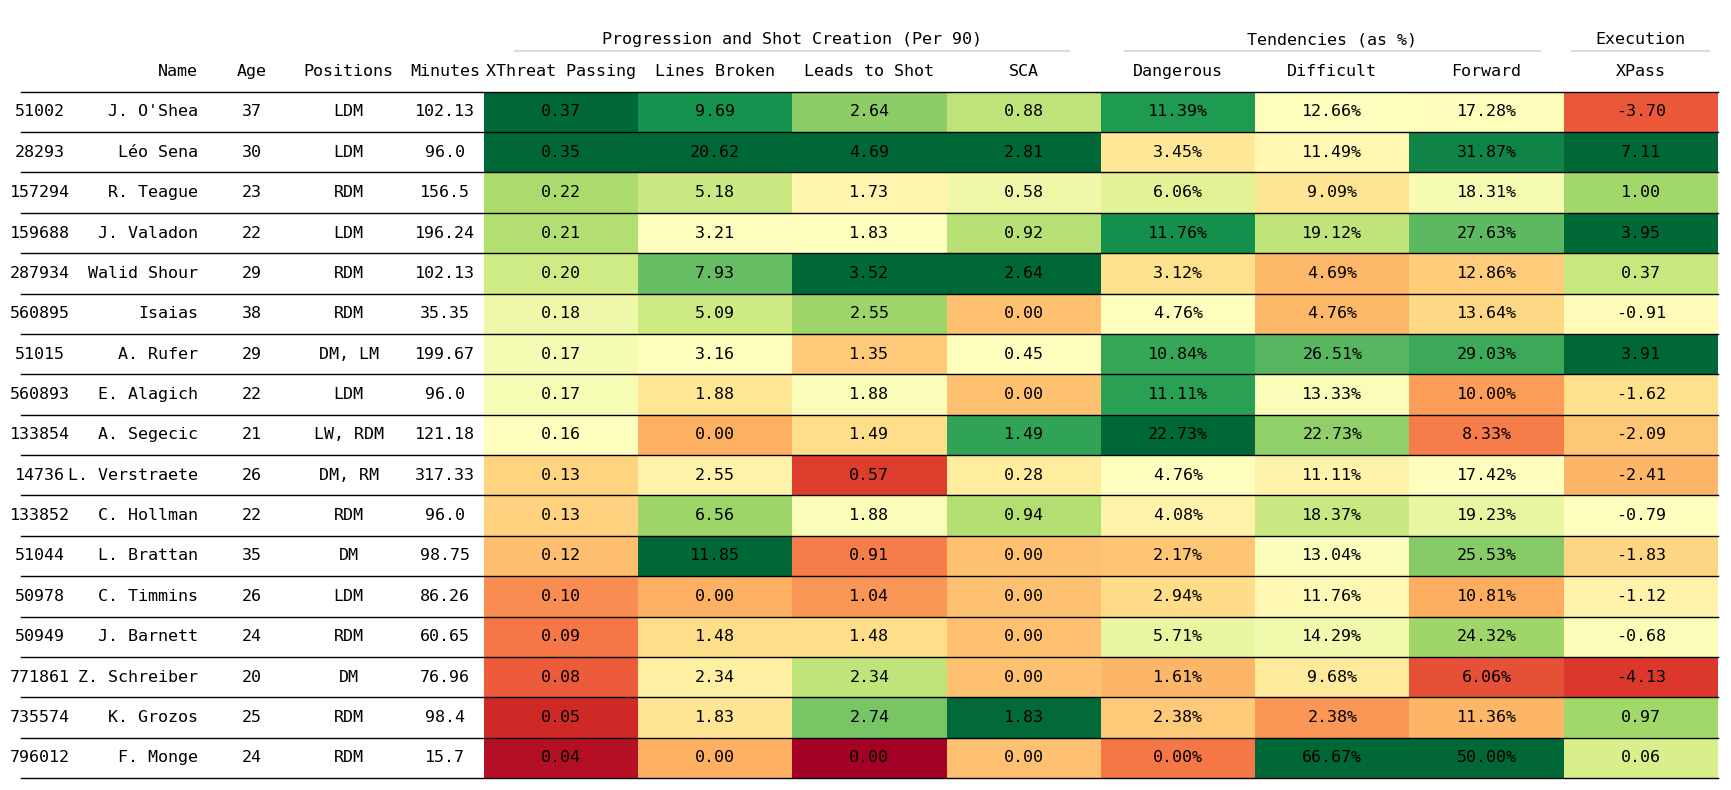

In [ ]:
df = DataLoader(matchids).data_loader_multi_match()

summary = ASIProjMetrics(df).format_aggregator()

summary = StyleAggregator(summary).style_aggregator()